<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Collecting Finetuning Dataset for Conversation Summarization</h1>

<img style="float: left;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Google_Colaboratory_SVG_Logo.svg/1600px-Google_Colaboratory_SVG_Logo.svg.png?20221103151432" width="150"/> <h1>Run on Google Colab <a href="https://colab.research.google.com/drive/1GEYff6lHbSOFbDbPaO5F4FL742TQZhbm?usp=sharing">here</a>.</h1> 

**Objective**: Collect a finetuning dataset to improve a model that summarizes human conversations.

**Model**: We are working on the `facebook/bart-large-xsum model` that was finetuned on the SAMSum dataset (available [here](https://huggingface.co/lidiya/bart-large-xsum-samsum)).
It is one of the [top performers](https://paperswithcode.com/sota/abstractive-text-summarization-on-samsum) in open-source models on the SAMSum corpus.

**Dataset**: Our model has been finetuned on the [SAMSum corpus](https://huggingface.co/datasets/samsum) which has 16k conversations and their summaries. Additionally, we evaluate our model on the [DialogSum corpus](https://huggingface.co/datasets/knkarthick/dialogsum) which has 13k conversations and their summaries. We note that the model has good performance on this new dataset as well, but slightly worse than its performance on the SAMSum dataset. Our objective is to create a finetuning dataset to improve the model on DialogSum like conversations.

**Method**: We employ several techniques to collect the fine-tuning dataset: 
1) Edge-case Collection (user defines the edge-case parameters) 
2) Building Custom Monitor (that checks out-of-vocabulary cases) 
3) Finding points where data drift has occured 
4) Finding clusters around points where accuracy is low
5) Visualizing UMAP/t-SNE for low-performing clusters

#### Install required packages

In [1]:
# !pip install uptrain rouge-score datasets umap-learn matplotlib py7zr 

In [2]:
from datasets import load_dataset
import json
import numpy as np
import os
import uptrain
from rouge import Rouge 
import random
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import zipfile

#### Load Datasets from Hugging Face

In [3]:
samsum_dataset = load_dataset("samsum")
dialogsum_dataset = load_dataset("knkarthick/dialogsum")

Found cached dataset samsum (/Users/vipul/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/Users/vipul/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/3 [00:00<?, ?it/s]

#### Download model outputs and their embeddings from remote
We understand that running the bart-large-xsum can be time consuming on sum machines, hence, we have pre-generated the model outputs and their corresponding sentence BERT embeddings to remote for both the SAMSum and DialogSUM datasets. Due to this, running this entire script does not take too much time (e.g., it runs in 3 minutes on my Macbook Air).

In [28]:
remote_url = "https://oodles-dev-training-data.s3.amazonaws.com/conversation_summarization_data.zip"
data_dir = 'data'
if not os.path.exists(data_dir):
    file_downloaded_ok = subprocess.call("wget " + remote_url, shell=True, 
                                         stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    print("Data downloaded.")
    with zipfile.ZipFile('conversation_summarization_data.zip', 'r') as zip_ref:
        zip_ref.extractall("./")
    print("Prepared Model Outputs.")
    os.remove('conversation_summarization_data.zip')
else:
    print("Skipping data download as it already exists.")

Skipping data download as it already exists.


Next, we analyze the above model outputs and define edge cases as follows.

### Edge-case type 1

**Observation**: Model performs badly for long dialogs. For example, it generates the following (incomplete) summaries for long dialogs:

```
"Benjamin, Elliot, Daniel and Hilary are going to have lunch with French"
"Jesse, Lee, Melvin and Maxine are going to chip in for the"
"Jayden doesn't want to have children now, but maybe in the future when"
"Leah met a creepy guy at the poetry reading last night. He asked her"
"Jen wants to break up with her boyfriend. He hasn't paid her back the"
```

Next, we generate a histogram of length of input dialogues on the training dataset (i.e., SAMSum train). From here, we note that a length of 1700 can be a good cut-off to collect large conversation data-points.

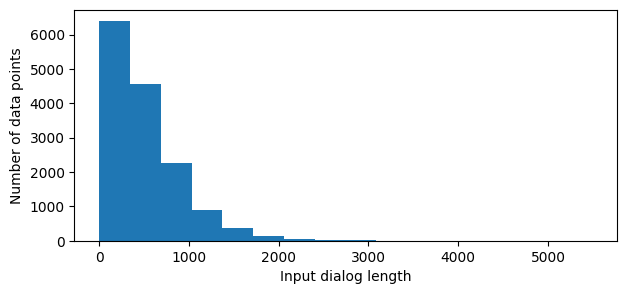

In [5]:
a = [len(x) for x in samsum_dataset['train']['dialogue']]
fig, ax = plt.subplots(figsize =(7, 3))
ax.hist(a, bins=16)
ax.set_xlabel('Input dialog length')
ax.set_ylabel('Number of data points')
plt.show()

In [6]:
"""
Check if the length of the input is greater 
than 1700 characters.
"""
def length_check_func(inputs, outputs, gts=None, extra_args={}):
    this_batch_dialog = inputs['dialog']
    return np.array([len(x) for x in this_batch_dialog]) > 1700

edge_case_length = {
    'type': uptrain.Monitor.EDGE_CASE,
    'signal_formulae': uptrain.Signal("Length_dialog", length_check_func)
} 

### Edge-case type 2

**Observation**: When the model is not able to summarize well, it just copies one or two sentences. This may work in general but performs very badly when we have a negation in the conversation. See the following examples: <br>

```
Input: 
Janice: my son has been asking me to get him a hamster for his birthday. Janice: Should I? Martina: NO! NO! NO! NO! NO! Martina: I got one for my son and it stank up the whole house. Martina: So don't do it!!!
Output: Janice's son wants her to get him a hamster for his birthday.

Input: 
Person1: Hello, I'm looking for a shop that sells inexpensive cashmere sweaters. Person2: Have you tried an outlet?Person1: Why didn't I think of that? Person2: Many of my friends shop at outlets. Person1: Thanks. That is a good suggestion. Person2: I'm only too happy to help.
Output: Person1 is looking for a shop that sells inexpensive cashmere sweaters.
```

In [7]:
# Checking whether sentences from inputs are copied directly using Rogue-L metric
def rogueL_check_func(inputs, outputs, gts=None, extra_args={}):
    r = Rouge()
    res = r.get_scores([x.lower() for x in inputs['dialog']],[x.lower() for x in outputs])
    rogue_l = [x['rouge-l']['f'] for x in res]
    return np.array(rogue_l)

# Cheking whether there's a negation in the input
def negation_func(inputs, outputs, gts=None, extra_args={}):
    has_negation = []
    for text in inputs['dialog']:
        this_has_negation = False
        all_words = text.split()
        for negation_word in ['no', 'not', "can't", "couldn't", "won't", "didn't", "don't"]:
            if negation_word in all_words:
                this_has_negation = True
        has_negation.append(this_has_negation)
    return has_negation

edge_case_negation = {
    'type': uptrain.Monitor.EDGE_CASE,
    'signal_formulae': (uptrain.Signal("Rogue-L", rogueL_check_func) > 0.3) 
        & uptrain.Signal("Has_negation", negation_func)
}

#### Custom Monitor to check Vocabulary Coverage

In this case, we define a custom monitor to see what's the average vocabulary coverage of the new dataset (i.e., DialogSum) on the old dataset (i.e., SAMSum). Defining a custom metric to check if there is a shift in vocabulary. Note that unlike previous edge cases checks that were stateless, this is a stateful check that contains the training vocabulary information.

In [8]:
from collections import Counter

def clean_string(x):
    x = x.lower()
    x = x.replace('.', '')
    x = x.replace(',', '')
    x = x.replace('\'', '')
    x = x.replace('?', '')
    x = x.replace('#', '')     
    x = x.replace(':', '')  
    x = x.replace('!', '')  
    return x

# Define the training vocabulary
all_text = ""
for x in samsum_dataset['train']['dialogue']:
    all_text += clean_string(x) + " "  
vocab = Counter(all_text.split())

"""
Used to define a state which contains the training set 
vocabulary and the out-of-vocab words (and their count).
"""
def vocab_init(self):
    # Reference (i.e. training) vocabulary
    self.vocab = set(vocab.keys())   
    self.vocab_arr = []
    self.out_of_vocab_words = Counter()

"""
This is the actual check that checks the vocabulary coverage 
of the production dataset in the training dataset.
"""
def vocab_drift(self, inputs, outputs, gts=None, extra_args={}):
    for x in inputs['dialog']:
        x_s = set(clean_string(x).split())
        self.vocab_arr.append(len(x_s & self.vocab)/len(x_s))
        outside_words = x_s - self.vocab
        self.out_of_vocab_words.update(Counter(outside_words))
        
        # Save 50 most common out of vocabulary words
        with open("out_of_vocab_words.json", "w") as f:
            json.dump(self.out_of_vocab_words.most_common(50), f)
        
        # Calculate vocabulary coverage
        count = len(self.vocab_arr)
        coverage = 100*sum(self.vocab_arr)/count

        # Logging to UpTrain dashboard
        self.log_handler.add_scalars('vocab coverage', 
                {'y_coverage': coverage},
            count, 'vocab_coverage', file_name='vocab_coverage')

# Defining a custom monitor check for vocabulary coverage
custom_monitor_check = {
    'type': uptrain.Monitor.CUSTOM_MONITOR,
    'initialize_func': vocab_init,
    'check_func': vocab_drift,
    'need_gt': False,
}

#### Defining UpTrain Config and Framework

In [9]:
config = {
    "checks": [edge_case_negation, edge_case_length, custom_monitor_check],
    "logging_args": {"st_logging": True},
    "retraining_folder": "smart_data_edge_case_and_custom_monitor",
}

framework = uptrain.Framework(cfg_dict=config)

Deleting the folder:  smart_data_edge_case_and_custom_monitor
Deleting the folder:  uptrain_logs


### Running model in production and logging data to UpTrain

In [10]:
# Run the model in production
def run_production(framework, batch_size=200):
    for dataset_name in ['samsum', 'dialogsum']:
        if dataset_name=='samsum':
            d_type = 'test'
            dataset = samsum_dataset[d_type]
        elif dataset_name=='dialogsum':
            d_type = 'train'
            dataset = dialogsum_dataset[d_type]
        else:
            raise Exception("Dataset Error")

        f = open(os.path.join(data_dir, f"out_{d_type}_{dataset_name}_summaries.json"))
        all_summaries = json.load(f)
        f.close()

        """
        Note: We use sentence BERT embeddings generated from here:
        https://huggingface.co/sentence-transformers
        But any other embeddings, such as the ones generated by the
        encoder can be used as well.
        """
        f = open(os.path.join(data_dir, f"out_{d_type}_{dataset_name}_bert_embs.json"))
        all_bert_embs = json.load(f)
        f.close()

        for idx in range(len(all_bert_embs)//batch_size):
            idxs = slice(idx*batch_size, (idx+1)*batch_size)
            this_batch = dataset['summary'][idxs]
            this_batch_dialog = dataset['dialogue'][idxs]

            inputs = {
                'id': list(range(idx*batch_size, (idx+1)*batch_size)),
                'bert_embs': np.array(all_bert_embs[idxs]),
                'dataset_label': [dataset_name]*batch_size,
                'dialog': this_batch_dialog,
                'summary': this_batch,
            }
            idens = framework.log(inputs=inputs, outputs=all_summaries[idxs])
        print(f"{(idx+1)*batch_size} predictions logged for {dataset_name} {d_type}")

In [11]:
run_production(framework)

62 edge cases identified out of 800 total samples
800 predictions logged for samsum test

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://192.168.6.64:8502

106 edge cases identified out of 1800 total samples
154 edge cases identified out of 3200 total samples
202 edge cases identified out of 4600 total samples
253 edge cases identified out of 5800 total samples
307 edge cases identified out of 7400 total samples
354 edge cases identified out of 8400 total samples
402 edge cases identified out of 9400 total samples
455 edge cases identified out of 10600 total samples
500 edge cases identified out of 11600 total samples
554 edge cases identified out of 13200 total samples
12400 predictions logged for dialogsum train


#### Vocabulary coverage

We obtain the following plot from the UpTrain dashboard to check vocabulary coverage in production data. Initially, (for SAMSum test), the coverage is ~98%, but later (for DialogSum), the coverage decreases to ~95%.

<img width="550" alt="concept_drift_avg_acc" src="https://uptrain-demo.s3.us-west-1.amazonaws.com/conversation_summarization/vocab_coverage.gif">

#### Checking the collected edge cases

In [12]:
# Print edge-cases collected for each reason
def print_edge_cases(csv_file, num_per_reason=2):
    df = pd.read_csv(csv_file)
    reasons_covered = Counter()
    
    for idx in range(len(df)):
        reason = [df['reasons'][idx]]
        count = reasons_covered.get(reason[0], 0)
        if count >= num_per_reason:
            continue
        reasons_covered.update(reason)
        print('Reason:           ', reason[0])
        print('Output:           ', df['output'][idx]) 
        print('Annotated Summary:', df['summary'][idx]) 
        print('Dialogue:         ', df['dialog'][idx])
        print('')

In [13]:
print_edge_cases(config['retraining_folder'] + "/1/smart_data.csv")

Reason:            "Signal-Length_dialog"
Output:            "Clara is rewatching Dear White People on Netflix and recommends it to Neela"
Annotated Summary: "Clara is rewatching Dear White People and strongly recommends it to Neela."
Dialogue:          "Clara: Hi, what you up to?\r\nNeela: Not much, chilling out.\r\nClara: Just rewatching Dear White People on Netflix, love it!\ud83d\ude0d\r\nNeela: Oh yeah, heard of it, but not seen it yet? Any good?\r\nClara: Well, yes! I just said it was, LOL. It's about a fictional Ivy League University and the students in one House of Residence.\r\nNeela: Why is it called Dear White People?\r\nClara: That's the name of the radio show the main character, Sam, presents on college radio.\r\nNeela: Yeah, but why is it so good?\r\nClara: Well, it's mainly stories from the perspective of black students there, which I find very interesting. The characters are strong and likeable too.\r\nNeela: I suppose it's rather different from the UK, then?\r\nClara: 

#### Get out-of-vocab-words 

In [14]:
f = open("out_of_vocab_words.json")
out_of_vocab_words = json.load(f)
f.close()
out_of_vocab_words = [x[0] for x in out_of_vocab_words]
print(out_of_vocab_words)

['person1', 'person2', 'yuan', 'person3', 'li', 'rmb', 'wang', 'taiwan', 'angeles', 'forty', 'fax', '00', 'clerk', 'twenty-five', 'branches', 'labor', 'furnished', 'advertisements', 'zhang', 'iba', 'forty-five', 'bye-bye', 'personnel', 'reporter', 'import', 'strengths', 'liu', 'automobile', 'non-smoking', 'assured', 'frequently', 'fourteen', 'appetizer', 'sellers', 'bid', 'eighty', 'ming', 'carry-on', 'airmail', 'consumer', 'chinas', 'sichuan', '[yeah]', 'weakness', 'organizations', 'honors', 'eighteen', 'singapore', 'exports', 'polluted']


Note from the above how a lot of the words are related to Asia (such as yuan, li, wang, taiwan, zhang, liu, chinas, sichaun, singapore, etc.). This implies that a lot of converation in the Dialogsum datasets are focused on the Asia region. Next, we define a edge-case check to catch these cases.

### Applying a check for Asian words on production data

In [15]:
asian_words = ['yuan', 'li', 'wang', 'taiwan', 'zhang', 'liu', 'chinas', 'sichaun', 'singapore']
def asian_words_check(inputs, outputs, gts=None, extra_args={}):
    has_asian_word = [False]*len(inputs['dialog'])
    for i,text in enumerate(inputs['dialog']):
        all_words = clean_string(text).split()
        if len(set(asian_words).intersection(set(all_words))):
            has_asian_word[i] = True
    return has_asian_word

edge_case_asian_word = {
    'type': uptrain.Monitor.EDGE_CASE,
    'signal_formulae': uptrain.Signal("asian_word", asian_words_check)
}

### Data Drift Detection

Finding points where BERT embeddings are further than the BERT emneddings of the reference dataset (SAMSum training in this case).

#### Define helper functions

In [16]:
"""
Using training data (i.e., SAMSum train), we generate and save a reference 
dataset to be used by the UpTrain framework. This dataset is used to detect 
drift, apply dimensioanlity reductions and compare visualizations.
"""
def generate_reference_dataset(summary, output_summaries_file, bert_embs_file, file_name, dataset_label):
    data = []
    if not os.path.exists(file_name):
        
        # Load model output summaries 
        f = open(output_summaries_file)
        output_summaries = json.load(f)
        f.close()
        
        # Load respective BERT embeddings of output summaries
        f = open(bert_embs_file)
        bert_embs = list(json.load(f))
        f.close()
        
        data = []
        for idx in range(len(bert_embs)):
            if isinstance(dataset_label, str):
                data.append({
                    'id': idx,
                    'dataset_label': dataset_label,
                    'summary': summary[idx],
                    'bert_embs': list(bert_embs[idx]),
                    'output': output_summaries[idx],
                })

        with open(file_name, "w") as f:
            json.dump(data, f, cls=uptrain.UpTrainEncoder)
        print("Generated reference dataset.")
    else:
        print("Reference dataset exists. Skipping generating again.")

#### Generate reference dataset to calculate drift and dimensionality reduction

In [17]:
data_dir = 'data'

# Get the locations of training-related data and outputs
output_summaries_file = os.path.join(data_dir, 'out_train_samsum_summaries.json')
bert_embs_file = os.path.join(data_dir, 'out_train_samsum_bert_embs.json')
reference_dataset_file = os.path.join(data_dir, 'reference_dataset.json')

# Generate and save reference dataset if not available 
generate_reference_dataset(samsum_dataset['train']['summary'], output_summaries_file, 
                           bert_embs_file, reference_dataset_file, 'reference')

Generated reference dataset.


#### Define a performance metric

In [18]:
"""
Define a performance metric. We use Rogue-L
similarity, but choose any metric that is 
relevant to your use-case.
"""
def rogue_l_similarity(text1_list, text2_list):
    r = Rouge()
    res = r.get_scores([x.lower() for x in text1_list],[x.lower() for x in text2_list])
    return [x['rouge-l']['f'] for x in res]

#### Get Rogue-L Performance scores on the Dialogsum Data 

In [19]:
file = os.path.join(data_dir, "out_train_dialogsum_summaries.json")
with open(file) as f:
    dialogsum_summaries = json.load(f)

dialogsum_gts = dialogsum_dataset['train']['summary'][0:len(dialogsum_summaries)]
dialogsum_scores = rogue_l_similarity(dialogsum_summaries, dialogsum_gts)

dialogsum_train_bert_embs_file = os.path.join(data_dir, 'out_train_dialogsum_bert_embs.json')
with open(dialogsum_train_bert_embs_file) as f:
    dialogsum_train_bert_embs = np.array(json.load(f))

#### Select bad-performing data-points

In [20]:
# Select data-points where Rogue-L scores are 0.0
outlier_idxs = np.where(np.array(dialogsum_scores) <= 0.0)[0]
selected_outliers = dialogsum_train_bert_embs[outlier_idxs, :]

#### Defining a Data-drift Check

In [21]:
drift_check = {
    'type': uptrain.Monitor.DATA_DRIFT,
    'is_embedding': True,
    'measurable_args': {
        'type': uptrain.MeasurableType.INPUT_FEATURE,
        'feature_name': 'bert_embs'
    },
    'reference_dataset': reference_dataset_file,
    # Number of clusters to calculate data drift
    "num_buckets": 50,
    # Number of points to wait before calculating drift
    "initial_skip": 500,
    # Outliers around which we want to collect data-points
    'outlier_data': selected_outliers,
    # Threshold for Earth-moving-distance (EMD) to collect drift points
    'emd_threshold': 10
}

#### Defining Dimensionality Reduction and Visualization using UMAP

In [22]:
umap_check = {
    'type': uptrain.Visual.UMAP,
    "measurable_args": {
        'type': uptrain.MeasurableType.INPUT_FEATURE,
        'feature_name': 'bert_embs'
    },
    "label_args": {
        'type': uptrain.MeasurableType.INPUT_FEATURE,
        'feature_name': 'dataset_label'
    },
    "hover_args": [
    {
        'type': uptrain.MeasurableType.INPUT_FEATURE,
        'feature_name': 'id'
    },
    {
        'type': uptrain.MeasurableType.PREDICTION,
        'feature_name': 'output'
    },
    {
        'type': uptrain.MeasurableType.INPUT_FEATURE,
        'feature_name': 'summary'
    },
    ],
    "update_freq": 13200,
    'initial_dataset': reference_dataset_file,
    "do_clustering": False,
}

#### Again, we define the UpTrain Config and Framework

In [23]:
config = {
    "checks": [edge_case_asian_word, drift_check, umap_check],
    "logging_args": {"st_logging": True},
    "retraining_folder": "data_drift_smart_data",
}

framework = uptrain.Framework(cfg_dict=config)

Deleting the folder:  data_drift_smart_data
Deleting the folder:  uptrain_logs


In [24]:
run_production(framework)

800 predictions logged for samsum test
60 edge cases identified out of 1800 total samples
108 edge cases identified out of 2600 total samples
161 edge cases identified out of 3600 total samples
202 edge cases identified out of 4200 total samples
256 edge cases identified out of 5200 total samples
309 edge cases identified out of 6200 total samples
358 edge cases identified out of 7000 total samples
402 edge cases identified out of 7600 total samples
450 edge cases identified out of 8200 total samples
506 edge cases identified out of 9000 total samples
553 edge cases identified out of 10000 total samples
604 edge cases identified out of 10800 total samples
656 edge cases identified out of 11600 total samples
702 edge cases identified out of 12200 total samples
759 edge cases identified out of 13000 total samples
12400 predictions logged for dialogsum train


#### Noting the performance of collected points that are close to the outliers (Disclaimer: It's 0.7 less)

In [25]:
print("Overall Accuracy (Rogue-L): ", np.mean(dialogsum_scores))

Overall Accuracy (Rogue-L):  0.3053099275310582


In [26]:
smart_data = pd.read_csv(config['retraining_folder'] + '/1/smart_data.csv') 
smart_data = smart_data[smart_data['reasons']=='"Close_to_User_annotated_Outliers"'].to_dict('records')
smart_data_scores = rogue_l_similarity([eval(x['output']) for x in smart_data], 
                                            [eval(x['summary']) for x in smart_data])
print("Accuracy on clusters around user-picked outliers", np.mean(smart_data_scores))

Accuracy on clusters around user-picked outliers 0.23727535781589845


Note how the accuracy obtained on points that are closer to outliers is worse compared to the overall accuracy.

#### Checking the collected edge cases

In [27]:
print_edge_cases(config['retraining_folder'] + "/1/smart_data.csv")

Reason:            "Outlier_annotated_by_the_user"
Output:            "#Person1# and #Person2# are at a party. #Person"
Annotated Summary: "Malik invites Nikki to dance. Nikki agrees if Malik doesn't mind getting his feet stepped on."
Dialogue:          "#Person1#: Watsup, ladies! Y'll looking'fine tonight. May I have this dance?\n#Person2#: He's cute! He looks like Tiger Woods! But, I can't dance. . .\n#Person1#: It's all good. I'll show you all the right moves. My name's Malik.\n#Person2#: Nice to meet you. I'm Wen, and this is Nikki.\n#Person1#: How you feeling', vista? Mind if I take your friend'round the dance floor?\n#Person2#: She doesn't mind if you don't mind getting your feet stepped on.\n#Person1#: Right. Cool! Let's go!"

Reason:            "Outlier_annotated_by_the_user"
Output:            "#Person2# gave birth to triplets. She doesn't want to have"
Annotated Summary: "#Person1# asks #Person2# whether she plans on having more babies. #Person2# refuses because #Person2# eve

#### UMAP Visualization

Datasets marked `reference` (i.e., SAMSum training) and `samsum` (i.e., SAMSum test) are close in the UMAP space. Most point from the DialogSum dataset are further than the data on which the model was finetuned on (i.e., reference aka SAMSum train).  

![](https://uptrain-demo.s3.us-west-1.amazonaws.com/conversation_summarization/umap_conv_summ.png)